In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle
import numpy as np

In [2]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_data_X, Y_data, test_size=0.33, random_state=42)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating initial dataframe

y_train_df = pd.DataFrame(y_train, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_train_df['New'] = labelencoder.fit_transform(y_train_df['Label'])
y_test_df = pd.DataFrame(y_test, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_test_df['New'] = labelencoder.fit_transform(y_test_df['Label'])

In [6]:
from keras import backend as K
img_rows, img_cols = X_train[0].shape


# transform data set
if K.common.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Using TensorFlow backend.


**Parseval Network**

**Constrait**

In [7]:
from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005


def initial_conv(input):

    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.common.image_dim_ordering() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.common.image_dim_ordering() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.common.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, W_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Parseval Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":
    from keras.utils import plot_model
    from keras.layers import Input
    from keras.models import Model

    init = (68, 100,1)

    wrn_28_10 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.0)

    wrn_28_10.summary()

   # plot_model(wrn_28_10, "WRN-16-2.png", show_shapes=True, show_layer_names=True)


Parseval Residual Network-16-2 created.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 68, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 68, 100, 16)  144         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 68, 100, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 68, 100, 16)  0           batch_normalization_1[0][0]      
____________________________________________________

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks as callbacks
import keras.utils.np_utils as kutils

In [0]:
EPOCHS = 60
BS = 128
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
horizontal_flip=True, fill_mode="nearest")

In [0]:
from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD
def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.2
  epochs_drop = 60
  lrate = 0.1
  if math.floor((1+epoch)/epochs_drop) !=0:
    lrate = initial_lrate*math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate
 
sgd = SGD(lr=0.1, momentum=0.9)

In [11]:
wrn_28_10.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

Finished compiling


In [12]:
from keras.utils import to_categorical

# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
hist = wrn_28_10.fit(X_train, to_categorical(y_train_df['New']), validation_split=0.33, epochs=EPOCHS, batch_size=BS, verbose=2, callbacks=callbacks_list)

Train on 2568 samples, validate on 1265 samples
Epoch 1/60
 - 20s - loss: 1.8638 - acc: 0.3135 - val_loss: 1.9661 - val_acc: 0.2925
Epoch 2/60
 - 9s - loss: 1.7620 - acc: 0.3727 - val_loss: 1.7481 - val_acc: 0.3723
Epoch 3/60
 - 9s - loss: 1.7021 - acc: 0.4120 - val_loss: 1.8281 - val_acc: 0.3668
Epoch 4/60
 - 9s - loss: 1.6959 - acc: 0.4054 - val_loss: 1.7173 - val_acc: 0.4348
Epoch 5/60
 - 9s - loss: 1.6607 - acc: 0.4268 - val_loss: 1.6639 - val_acc: 0.4364
Epoch 6/60
 - 9s - loss: 1.6036 - acc: 0.4556 - val_loss: 1.6125 - val_acc: 0.4482
Epoch 7/60
 - 9s - loss: 1.5678 - acc: 0.4743 - val_loss: 1.5755 - val_acc: 0.4719
Epoch 8/60
 - 9s - loss: 1.4852 - acc: 0.5136 - val_loss: 1.7548 - val_acc: 0.3881
Epoch 9/60
 - 9s - loss: 1.4190 - acc: 0.5502 - val_loss: 1.5735 - val_acc: 0.5186
Epoch 10/60
 - 9s - loss: 1.4161 - acc: 0.5483 - val_loss: 1.4879 - val_acc: 0.5241
Epoch 11/60
 - 9s - loss: 1.3617 - acc: 0.5678 - val_loss: 1.5066 - val_acc: 0.5075
Epoch 12/60
 - 9s - loss: 1.3012 - a

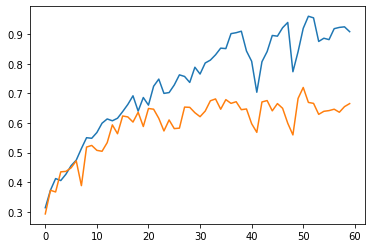

In [13]:
from matplotlib import  pyplot


pyplot.plot(hist.history["acc"], label='train')
pyplot.plot(hist.history['val_acc'], label='test')


In [0]:
import tensorflow as tf
wrn_28_10.save("parseval_orthogonal.h5")